# Bagging 분류 하이퍼 파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 최적의 성능을 보이는 모델
from sklearn.linear_model import LogisticRegression

# 배깅 앙상블
from sklearn.ensemble import BaggingClassifier

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기


In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 전처리

`0` 값을 포함해서는 안되는 변수에 대해 평균으로 대체


In [3]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [4] 훈련/검증 데이터 분할 및 데이터 표준화


In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. 하이퍼파라미터 튜닝

### [1] 최적 성능을 보인 모형 객체 생성

이전 예제에서 이 데이터에 대한 최적 모형은 LogisticRegression 이었다.


In [5]:
estimator = get_estimator(classname=LogisticRegression)
estimator

LogisticRegression(n_jobs=-1, random_state=0, verbose=False)

### [2] 하이퍼파라미터

#### (1) 최적성능을 보인 모형에 대한 파라미터


In [6]:
params = get_hyper_params(classname=LogisticRegression, key='estimator')
params

{}

#### (2) Bagging 모형에 대한 파라미터


In [7]:
bagging_params = get_hyper_params(classname=BaggingClassifier)
bagging_params

{'bootstrap_features': [False, True],
 'n_estimators': [10, 20, 50, 100],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

#### (3) 하이퍼파라미터 결합


In [8]:
params.update(bagging_params)
params

{'bootstrap_features': [False, True],
 'n_estimators': [10, 20, 50, 100],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

### [3] 하이퍼파라미터 튜닝


In [9]:
rcv = RandomizedSearchCV(
    estimator=BaggingClassifier(estimator=estimator, random_state=get_random_state()), 
    param_distributions=params, 
    n_iter=get_max_iter(), 
    n_jobs=get_n_jobs(),
    random_state=get_random_state(), 
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.dropna(subset=['mean_test_score'], inplace=True)
result_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

result_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,n_estimators,max_samples,max_features,bootstrap_features,mean_test_score
4,10,0.7,0.5,False,0.763854
68,10,1.0,1.0,True,0.763854
9,20,1.0,0.5,False,0.763854
28,10,0.7,1.0,False,0.762255
30,50,0.7,1.0,False,0.762255
...,...,...,...,...,...
40,10,0.7,0.5,True,0.741064
53,20,0.7,0.7,True,0.739438
45,20,1.0,0.5,True,0.732920
37,20,0.5,0.5,True,0.729655


### [4] 성능평가


+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.762215 |     0.805195 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.762238 |     0.757576 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.493213 |     0.531915 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.086514 |    0.0747664 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.913486 |     0.925234 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.598901 |        0.625 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.826155 |     0.889044 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

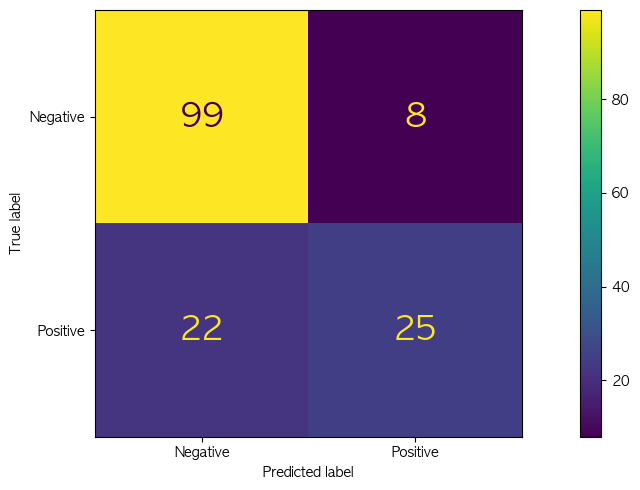

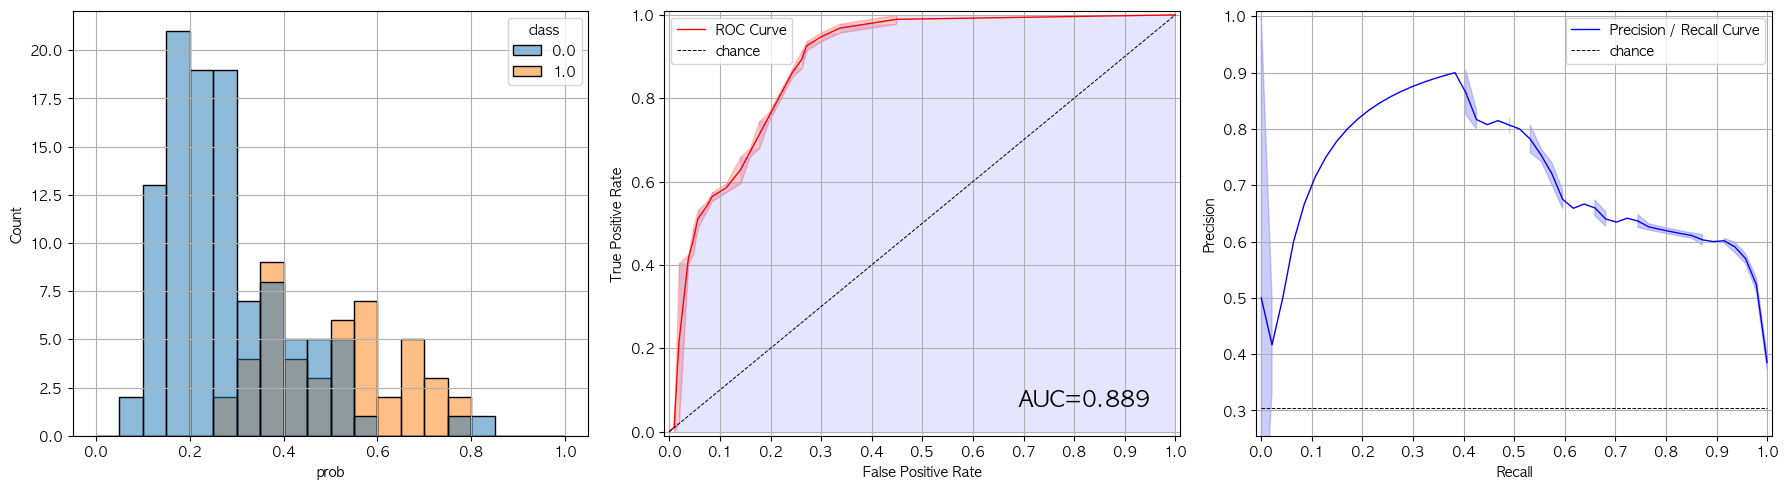

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 

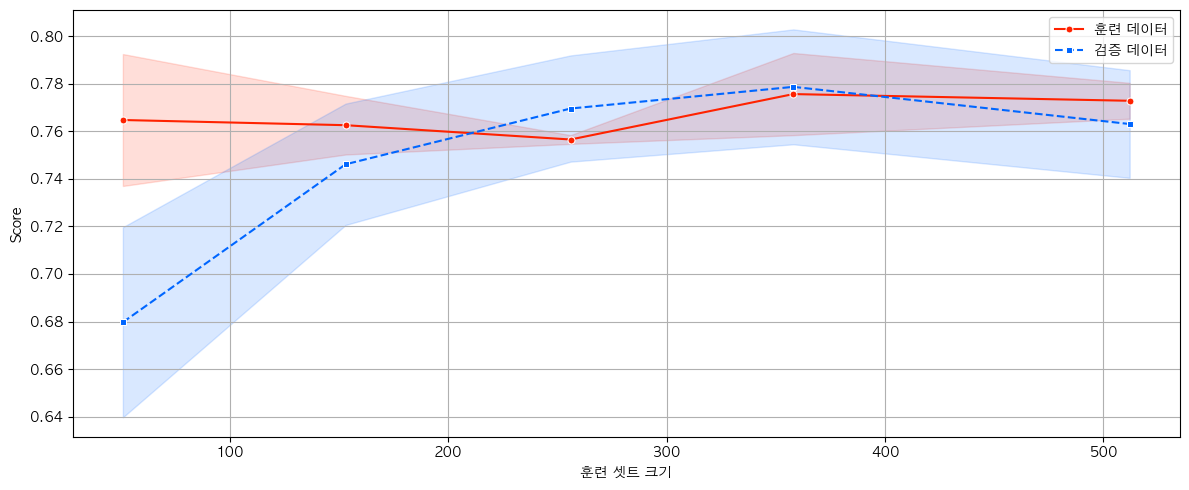

In [10]:
my_classification_result(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [5] 독립변수 확인


In [11]:
my_classification_report(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+


## #03. 모듈화 기능 활용

### [1] 직접 생성한 분석기 객체를 전달하는 경우


[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+-------------------|
|  0 |             50 |           0.7 |              1 | False                |          0.762255 |
|  1 |             50 |             1 |              1 | False                |          0.762255 |
|  2 |             50 |             1 |            0.7 | False                |          0.762242 |
|  3 |            100 |           0.5 |              1 | False                |          0.760629 |
|  4 |             50 |           0.5 |              1 | False                |          0.759003 |
+----+----------------+---------------+----------------+----------------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_samples': 0.7, 'max_features': 1.0, 'bootstrap_

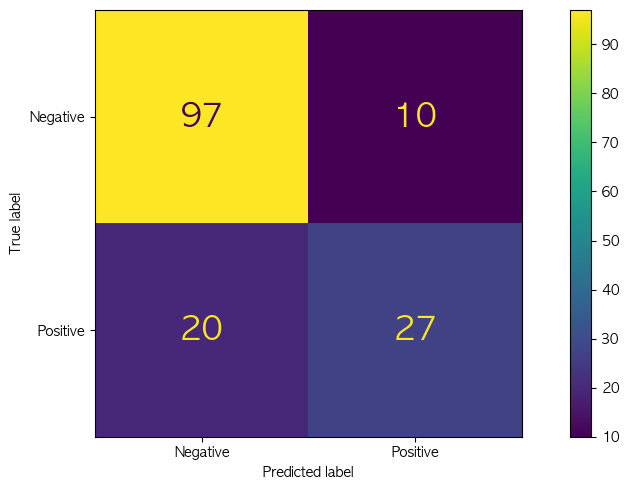

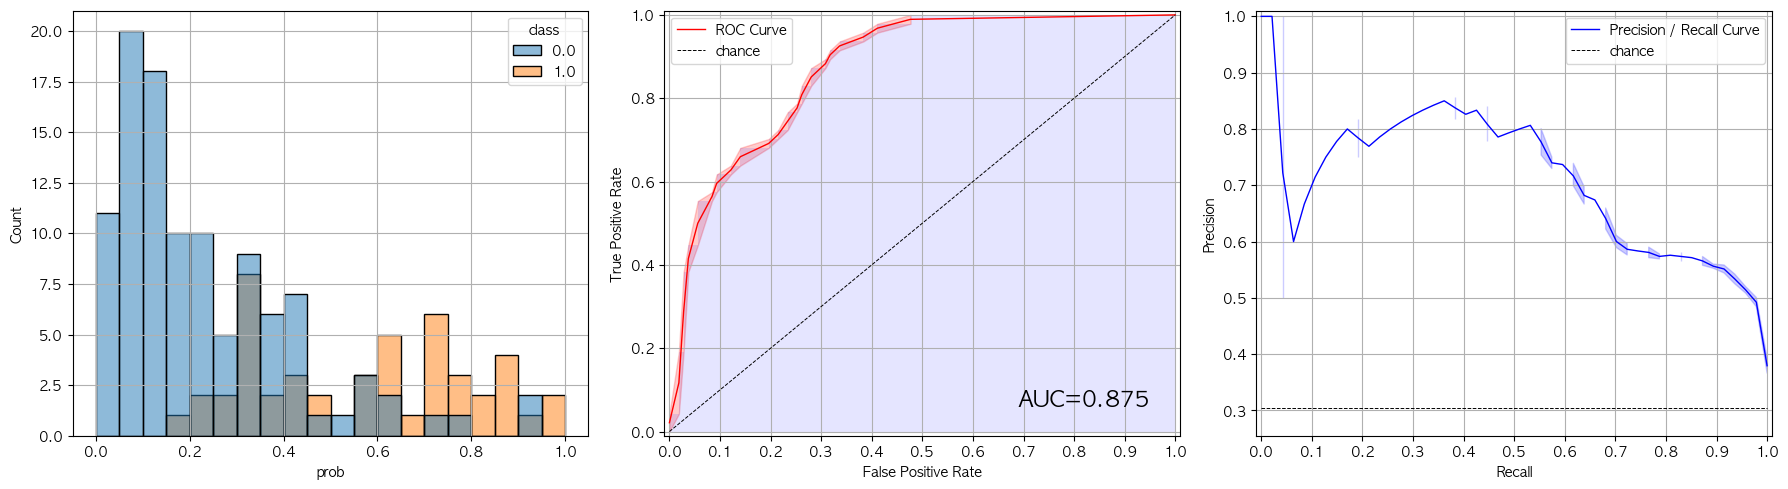

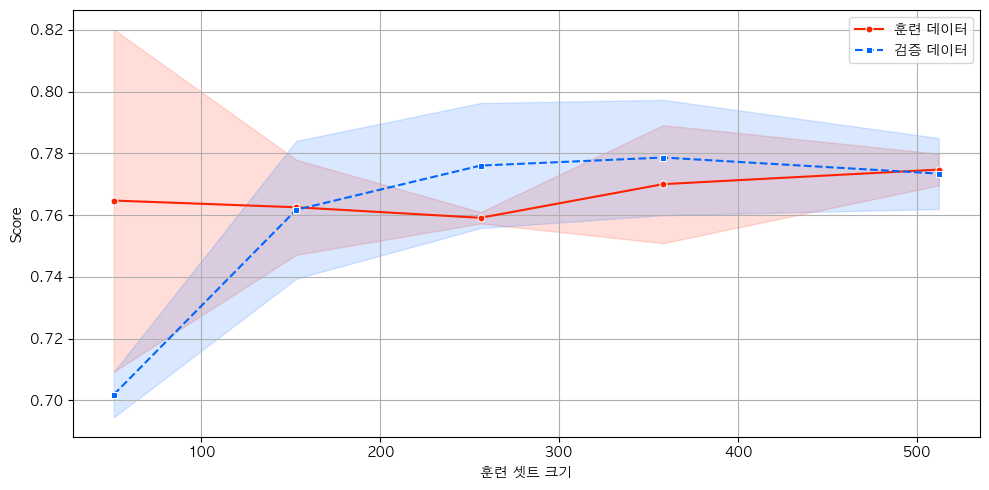

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=0,
                                               verbose=False),
                  max_samples=0.7, n_estimators=50, n_jobs=-1, random_state=0,
                  verbose=False)

In [12]:
my_bagging_classification(estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [2] 분석기 객체에 대한 클래스만 전달하는 경우

모듈 내부에서 객체를 생성하여 수행한다.


[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+-------------------|
|  0 |             50 |           0.7 |              1 | False                |          0.762255 |
|  1 |             50 |             1 |              1 | False                |          0.762255 |
|  2 |             50 |             1 |            0.7 | False                |          0.762242 |
|  3 |            100 |           0.5 |              1 | False                |          0.760629 |
|  4 |             50 |           0.5 |              1 | False                |          0.759003 |
+----+----------------+---------------+----------------+----------------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_samples': 0.7, 'max_features': 1.0, 'bootstrap_

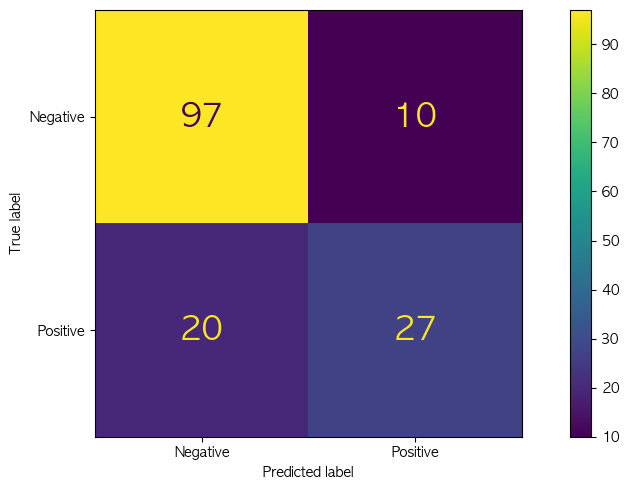

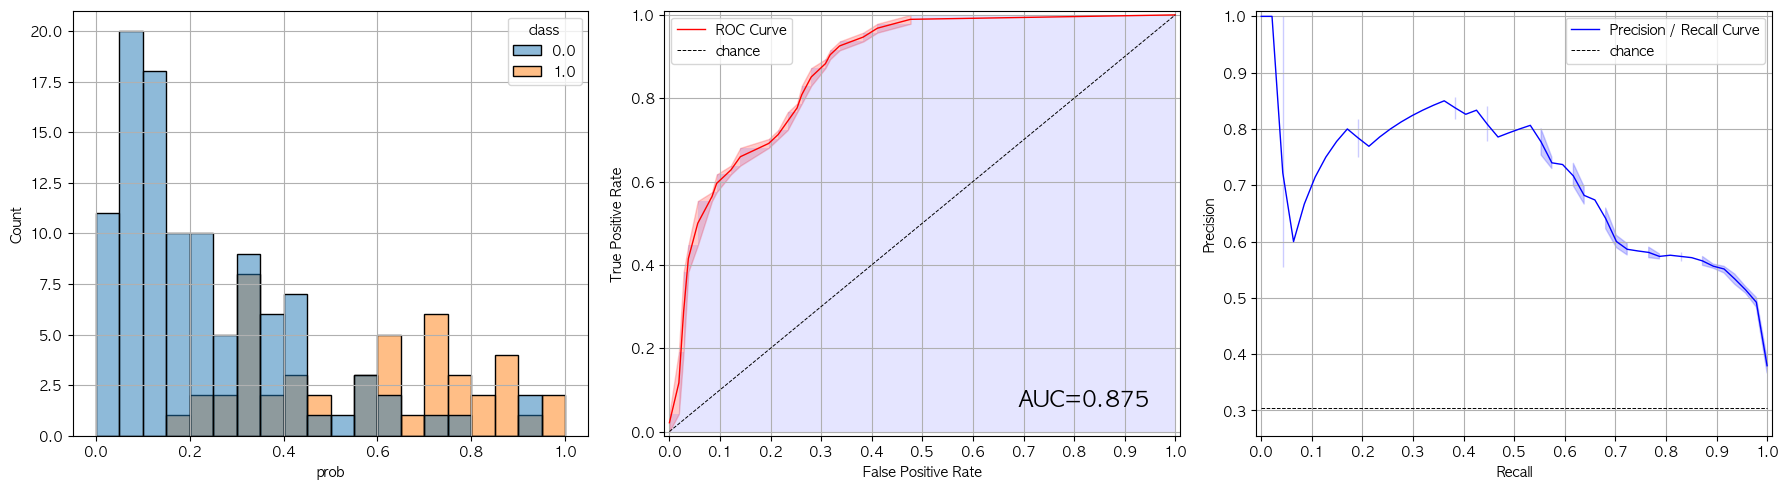

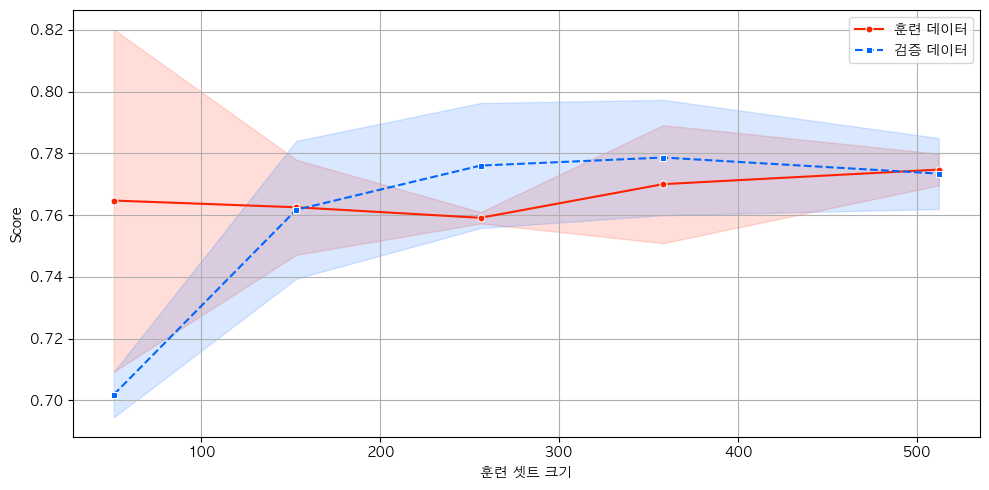

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=0,
                                               verbose=False),
                  max_samples=0.7, n_estimators=50, n_jobs=-1, random_state=0,
                  verbose=False)

In [13]:
my_bagging_classification(estimator=LogisticRegression, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [3] 분석기 객체 정보를 전달하지 않는 경우

모듈 내부에서 최적 모형을 찾은 후 배깅에 적용한다.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller th



+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| LogisticRegression     |                  0.311133 |           0.811688 |            0.736842 |         0.595745 |           0.0934579 |      0.906542 |   0.658824 | 0.875522 |
| SVC                    |                         0 |           0.772727 |            0.657895 |         0.531915 |            0.121495 |      0.878505 |   0.588235 | 0.855438 |
| KNeighborsClassifier   |                         0 |           0.766234 |            0.612245 |         0.638298 |         

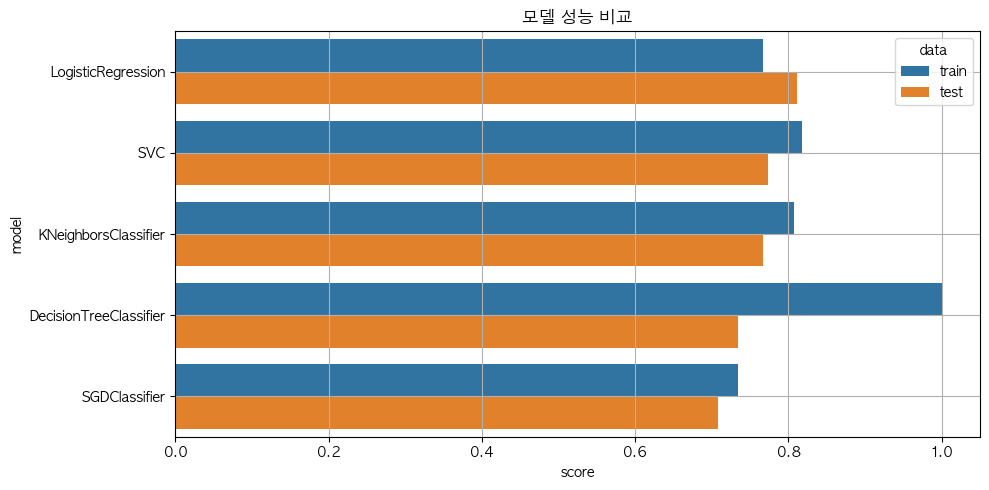



+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.270997 |     0.311133 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.767101 |     0.811688 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision)       |     0.724138 |     0.736842 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)          |     0.570136 |     0.595745 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout)       |     0.122137 |    0.0934579 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)             |     0.877863 |     0.906542 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score                |     0.637975 |     0.658824 | 정밀도와 재현율의 조화평균  

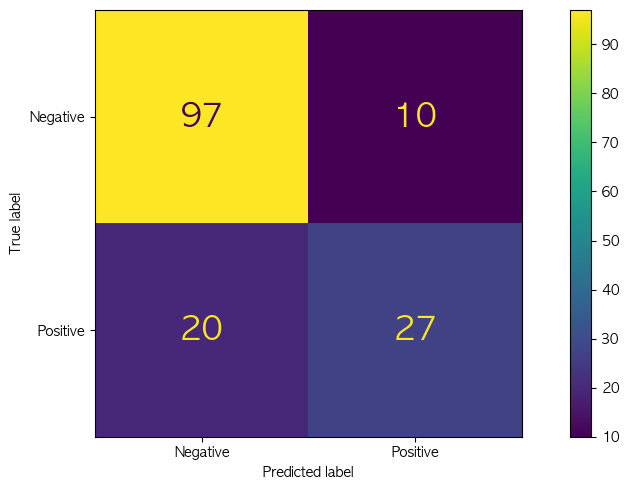

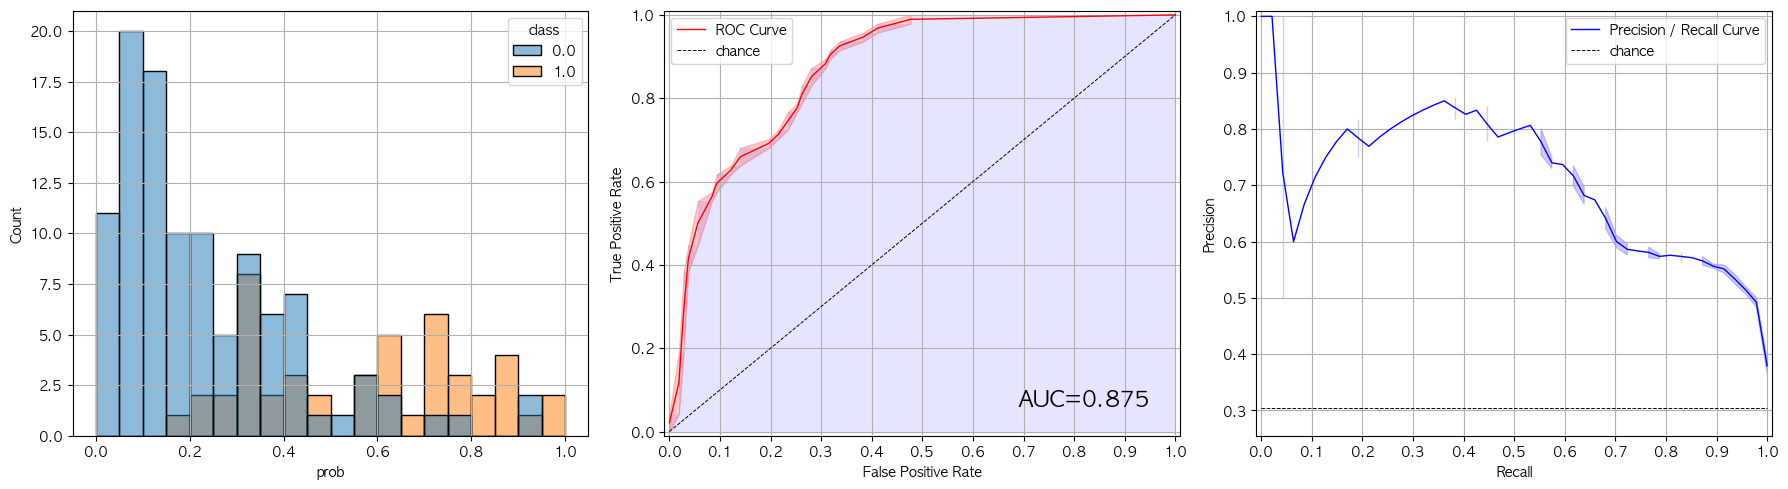

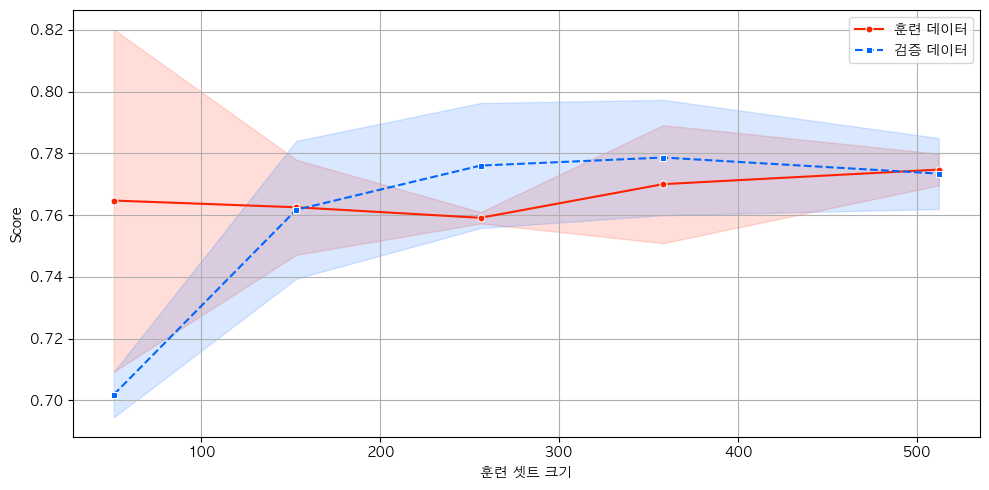

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=0,
                                               verbose=False),
                  max_samples=0.7, n_estimators=50, n_jobs=-1, random_state=0,
                  verbose=False)

In [14]:
my_bagging_classification(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)